In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from matplotlib.animation import FuncAnimation
import numpy as np
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(color_codes=True)

In [56]:
df = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/housing.json",lines=True)
# remove null or missing values
df = df.loc[~df['title'].isnull()]
df.loc[df['rooms']!='']

# filter by apartment types
df = df.loc[df['posted_type'].isin(['Apartment for rent','Shared apartment','House for rent','Service Apartment'])]

# filter for prices like 10,000 RMB or 10,000 rmb or 10,000 or RMB10,000
df = df.loc[df['price'].str.contains('^[0-9,]{3,} RMB$|^[0-9,]{3,} rmb$|^[0-9,]{3,}$|^RMB[0-9,]{3,}$')]
# strip unnecessary characters and convert to int
df['price']=df['price'].str.replace('RMB', '', case=True).str.replace(',','').str.strip().astype('int')
df = df.loc[df['price'] < df['price'].quantile(q=0.99)]

# truncate publish_time column into dates and months
df['publish_date'] = df['publish_time'].dt.date
df['publish_month'] = pd.to_datetime(dict(year=df['publish_time'].dt.year, month=df['publish_time'].dt.month, day=1))
df['pub_month'] = df['publish_month'].dt.month
df['publish_week']=(df['publish_time'] - pd.to_timedelta(df['publish_time'].dt.dayofweek, unit='d')).dt.date
# show dataframe

#create rooms columns
df['rooms'] = df['rooms'].str.replace(', [0-9]* Storage','').str.strip()
df.loc[df['rooms']=='']
df['rooms_BR'] = df['rooms'].str.extract('([0-9]*) Bedroom',0).fillna(0).astype('int') + df['rooms'].str.extract('.*, ([0-9]*) Kids Rooms',0).fillna(0).astype('int')
df['rooms_BA'] = df['rooms'].str.extract('.*, ([0-9]*) Bathroom',0).fillna(0).astype('int')

df['rooms_simple'] = df['rooms_BR'].astype('str') + "BR, "+ df['rooms_BA'].astype('str') + "BA"

for i in xrange(0,4):
    # filtering out top 10% apartments and bottom 1%
    upper_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.95)
    lower_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.01)
    df = df.loc[~((df['price']>upper_lim) & (df['rooms_BR']==i))]
    df = df.loc[~((df['price']<lower_lim) & (df['rooms_BR']==i))]
    
# Define columns
main_cols = ['area','author','description','floor','latitude',
             'longitude','listing_id','posted_type','price','publish_time','rooms','size','title']
checkbox_cols = ['air_filter','central_aircon','balcony','dryer','dvd_player','elevator',
                 'floor_heating','health_club','outdoor_space','oven','parking','playground','pool',
                'security','tv','wall_heating','washing_machine','water_filter']

# Show weeks in which we pulled the most data
weeks = df['publish_week'].value_counts()[0:6].index
weeks = weeks.sort_values()

df = df.loc[df['longitude'].astype('str')!='']
df = df.loc[df['latitude'].astype('str')!='']
print df.shape

(19520, 42)


In [60]:
df['longitude'] = df['longitude'].astype('float')
df['latitude'] = df['latitude'].astype('float')
# df['longitude'].replace(r'\s+', np.nan, regex=True)
# df.loc[df['longitude']=='']['longitude']

In [64]:
def round_and_combine(value):
    return tuple(np.round(value,3))
df['lat_long'] = df[['latitude', 'longitude']].apply(round_and_combine, axis=1)
df['lat_long'].value_counts()

(31.25, 121.434)     168
(31.237, 121.444)    130
(31.198, 121.44)      82
(31.24, 121.449)      58
(31.234, 121.449)     51
(31.215, 121.465)     48
(31.261, 121.448)     47
(31.196, 121.446)     43
(31.247, 121.481)     42
(31.215, 121.466)     37
(31.237, 121.454)     37
(31.239, 121.453)     37
(31.216, 121.465)     36
(31.222, 121.49)      36
(31.237, 121.453)     35
(31.228, 121.462)     35
(31.215, 121.464)     35
(31.216, 121.466)     33
(31.229, 121.461)     33
(31.235, 121.447)     32
(31.227, 121.438)     32
(31.247, 121.465)     31
(31.24, 121.448)      30
(31.223, 121.445)     30
(31.217, 121.454)     29
(31.213, 121.451)     29
(31.211, 121.464)     29
(31.246, 121.451)     27
(31.212, 121.467)     27
(31.234, 121.448)     26
                    ... 
(nan, nan)             1
(nan, nan)             1
(31.215, 121.479)      1
(31.279, 121.434)      1
(31.187, 121.455)      1
(31.236, 121.549)      1
(31.259, 121.594)      1
(nan, nan)             1
(31.204, 121.449)      1


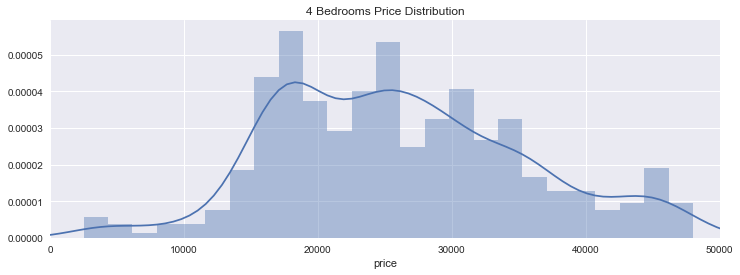

In [96]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==4) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("4 Bedrooms Price Distribution")
plt.xlim(0,50000)
plt.show()

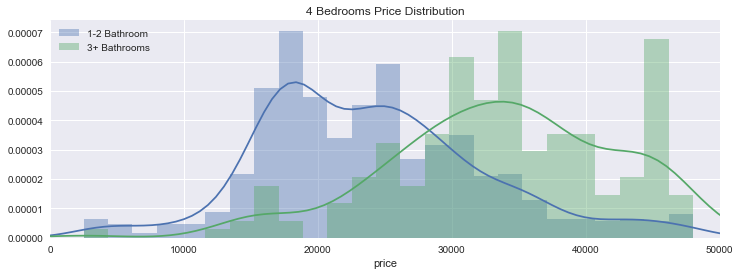

In [111]:
plt.figure(figsize=(12,4))
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']<=2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1-2 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='3+ Bathrooms')

plt.title("4 Bedrooms Price Distribution")
plt.legend()
plt.xlim(0,50000)
plt.show()

In [125]:
df['description'].str.contains('french|French|laofang|Laofang').value_counts()
df['title'].str.contains('french|French|laofang|Laofang').value_counts()
df['area'].value_counts()


Xuhui                   6039
Jing'an                 5445
Huangpu                 2006
Changning               1981
Xujiahui                 886
Putuo                    858
-                        582
Pudong                   575
People's Square          219
Zhabei                   151
Hongkou                  130
Gubei                     93
Hongqiao                  80
Yangpu                    79
Minhang                   77
Bund Area                 65
Suzhou Creek              60
Old Town (Yu Garden)      50
Qingpu                    37
Baoshan                   25
Jiading                   17
Jinqiao                   15
Chongming                  9
Jinshan                    8
Songjiang                  7
Expo Area                  4
South Bund                 1
Anting                     1
Name: area, dtype: int64

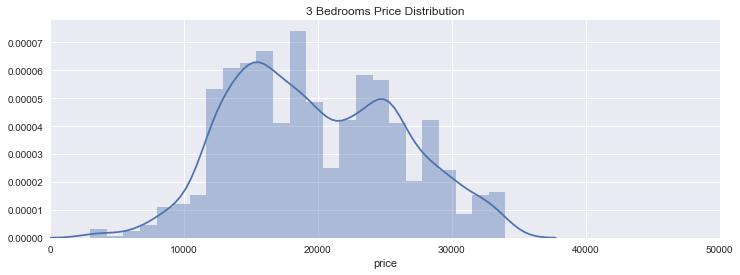

In [95]:
plt.figure(figsize=(12,4))
sns.distplot(df.loc[(df['rooms_BR']==3) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("3 Bedrooms Price Distribution")
plt.xlim(0,50000)
plt.show()

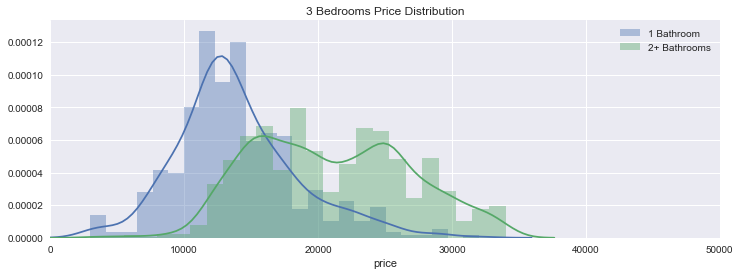

In [102]:
plt.figure(figsize=(12,4))
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']>1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2+ Bathrooms')

plt.title("3 Bedrooms Price Distribution")
plt.legend()
plt.xlim(0,50000)
plt.show()

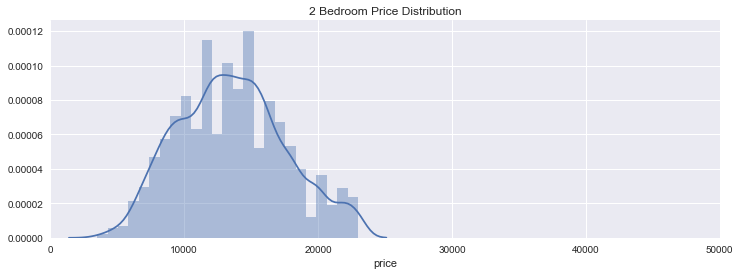

In [94]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("2 Bedroom Price Distribution")
plt.xlim(0,50000)
plt.show()

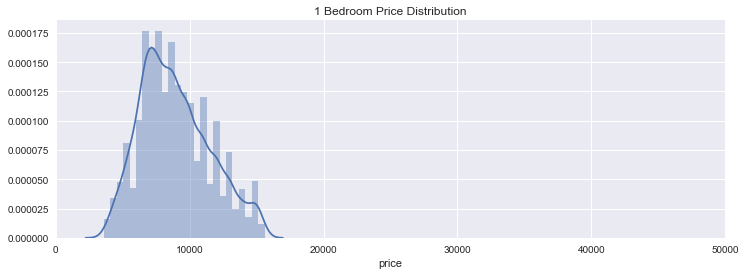

In [93]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("1 Bedroom Price Distribution")
plt.xlim(0,50000)
plt.show()

In [67]:
df.loc[(df['rooms_BR']==2)]['posted_type'].value_counts()

Apartment for rent    6109
House for rent         172
Shared apartment       132
Service Apartment       27
Name: posted_type, dtype: int64

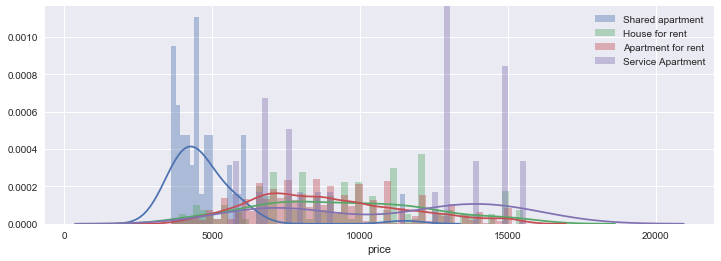

In [70]:
plt.figure(figsize=(12,4))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Shared apartment')]['price'],bins=50,label='Shared apartment')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='House for rent')]['price'],bins=50,label='House for rent')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Apartment for rent')]['price'],bins=50,label='Apartment for rent')
sns.distplot(df.loc[(df['rooms_BR']==1) & (df['posted_type']=='Service Apartment')]['price'],bins=50,label='Service Apartment')
plt.legend()
plt.show()

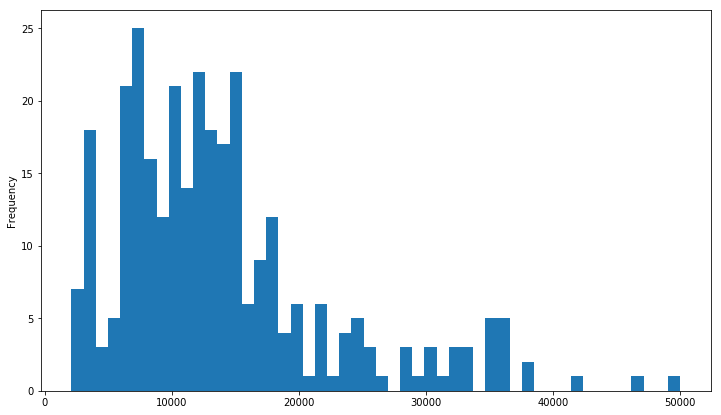

In [10]:
plt.figure(figsize=(12,7))
df.loc[df['publish_date'] == dt(2017,6,11).date()]['price'].plot.hist(bins=50)
plt.show()

In [11]:
plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[1])
sns.distplot(df.loc[df['publish_week'] == weeks[1]]['price'], bins=50, kde=False)
plt.show()

NameError: name 'weeks' is not defined

In [72]:
import seaborn as sns
sns.set(color_codes=True)

plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[4])
for i in xrange(1,4): #df['rooms_BR'].value_counts()[0:3].index:
    print i
    sns.distplot(df.loc[df['publish_week'] == weeks[4]].loc[df['rooms_BR']==i]['price'], bins=20, kde=False,label=str(i));
#     df.loc[df['publish_week'] == weeks[1]].loc[df['rooms_simple']==type]['price'].plot.hist(bins=50)
# df.hist(column='price',bins=50,by='rooms_simple')
# sns.distplot(df.loc[df['publish_week'] == weeks[1]].loc[~df['rooms_simple'].isin(top4_rooms)]['price'], bins=50, kde=False,label="other")
plt.legend()
plt.show()

NameError: name 'weeks' is not defined

In [ ]:



fig = plt.figure(figsize=(12,7))  
def update(i):
    plt.cla()

    plt.title('Week: {0}'.format(weeks[i]), fontsize=20)
    dfshow = df.loc[df['publish_week'] == weeks[i]]
    if not dfshow.empty:
        dfshow['price'].plot.hist(bins=50)

anim = FuncAnimation(fig, update, frames=np.arange(0,len(weeks)), interval=2000)

anim.save('line.gif', dpi=80, writer='imagemagick')

In [ ]:
import os
os.getcwd()

In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==6]['price'].plot.hist(bins=50)
plt.show()


In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==9]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
900*20